***Wolves vs Prey***

This code is intended to produce a simulation of wolf and prey populations over a specified time series.  The classroom discussion led to the following PRELIMINARY details about the simulation:

Here is [an interesting reference](https://www.researchgate.net/publication/239927489_Kill_Rates_and_Predation_by_Wolves_on_Ungulate_Populations_in_Bialowieza_Primeval_Forest_Poland?enrichId=rgreq-644c6d606fbbf71d082d4cbb0ade1da6-XXX&enrichSource=Y292ZXJQYWdlOzIzOTkyNzQ4OTtBUzo5ODg2MTU3NDAwMDY1M0AxNDAwNTgxODQ2ODMz&el=1_x_2&_esc=publicationCoverPdf) for wolf-prey dynamics.

**Goal:** Predict wolf and prey population N years beyond initial conditions

**Global assumptions:**
  * Isolated habitat with no human interactions
  * Restricted habitat area, forcing variable density
  * Modeling averages over single year periods (time step = 1 year)
  * No animal migration

  
**Input:**
  * Initial wolf population, assume equal male/female?  Ages?  Numbers of each.
  * Prey population, within limited species (rabbits, deer, moose, ??).
  * Animal reproduction rate: 2->N average per year (2->N is a bit arbitrary).  Does this depend on density?
  * Wolf predation rate per species (depends on population density?)
  * Habitat size (determines densities)
  * Weather adversity index (separately for wolves and prey)
  * Disease advertity index (separately for wolves and prey)
  * Average animal lifetimes

  
**Model details/assumptions:**
  * Require relationships between preditor and prey densities vs predation rate
  * Require relationship between prey density and food competition?
      * And also weather adversity?
      * Or assume general abundance?
  * No dependence of predation rate on age?
  * Require relationship between weather adversity and animal death rate
  * Require relationship between disease adversity and animal death rate
  * Require list of animal attributes & their population distribution
  * Require means to pass down traits to offspring (eg, hunting skill or reproduction rate)
  * Require model for prey density vs preditor survival rate



**Model implementation:**
  * Define class for a given animal,
      * Decorate with required variables to track animal attributes
  * Generate arrays of each species type, populated according to initial conditions
  * Iterate one year time steps
      * Calculate animal densities
      * Determine death events, remove dead animals from arrays (dead animals don't reproduce)
      * Determine birth events, adding new animals with new attributes drawn from parents
      * Repeat until desired future year

In [1]:
import numpy as np
from scipy.stats import weibull_min # import Weibull distribution
import matplotlib.pyplot as plt # import plotting
import time

In [2]:
###################################
## Global simulation parameters:
## nWolf_init: Initial wolf population size (integer)
## nPrey_init: Initial prey population size (integer)
## wolf_age_init: Average age of initial wolf population
## prey_age_init: Average age of initial prey population
##
## wolf_repro_rate: Average number of wolf pups per year from an average wolf (integer)
## prey_repro_rate: Average number of prey offspring per year from an average animal (integer)
##
## wolf_pred_rate: Average number of prey animals each wolf consumes per year (integer)
## wolf_pred_min: Minimum number of prey animals that a wolf must consume per year to survive (integer)
##
## wolf_lifetime: Average wolf natural lifetime in years (integer)
## prey_lifetime: Average prey natural lifetime in years (integer)
##
## habitat_size: Size of habitat in square kilometers 
## weather_idx: Weather & disaster adversity index [0,1]
## disease_idx: Disease adversity index [0,1]
##
## wolf_pop_std: Standard deviation of wolf population 
###################################


## Initial population variables
nWolf_init = 10
nPrey_init = 1000
wolf_age_init = 5
prey_age_init = 2

## Reproduction rate & lifetime variables
wolf_repro_rate = 2  # Average wolf pup rate (average is 4, but we divide by 2 because we don't track gender)
prey_repro_rate = 3  # Average prey offspring rate (again, division by 2 baked in)
wolf_repro_rate_std = 0.25 # 25% standard deviation on wolf 
prey_repro_rate_std = 0.25 # 25% standard deviation

wolf_lifetime = 15 # This is the theoretical maximum
prey_lifetime = 10 # This is the theoretical maximum

## Wolf predation variables
wolf_pred_rate = 40 # number of prey each wolf consumes each year on average
wolf_pred_min = 20 # minimum number of prey a wolf must consume per year to avoid dying of hunger
wolf_pred_std = 0.25 # standard deviation of wolf prey consumption, 20%

# environment variables
habitat_size = 500 # square kilometers
weather_idx = 0.5
disease_idx = 0.5

In [3]:
# This is the class that we'll use for an individual wolf.  It can be edited as needed.
class wolf:
    def __init__(self,age,pred_idx,repro_idx):
        self.age = age #This is the age of the wolf, which will increment each year
        self.pred_idx = pred_idx #This is an index [0,1] to describe this wolf's predatory skill
        self.repro_idx = repro_idx #This is an index [0,1] to describe this wolf's reproduction success rate
    
    def increaseAge(self): #increment age by one year
        self.age = self.age + 1
    
    def getAge(self): #Get current age of wolf
         return self.age
        
# This is the class that we'll use for an individual prey animal.  It can be edited as needed.
class prey:
    def __init__(self,age,repro_idx):
        self.age = age #This is the age of the prey animal, which will increment each year
        self.repro_idx = repro_idx #This is an index [0,1] to describe this animal's reproduction success rate
    
    def increaseAge(self): #increment age by one year
        self.age = self.age + 1
    
    def getAge(self): #Get current age of prey
        return self.age


In [4]:
# These functions will create the initial populations of 
def initializeWolves(nWolves, avgAge):
    # create initial set of randomized wolves: newWolf = wolf(randomAge, randomPidx, randomRidx)
    # return array of wolf objects
    # set all characteristics to 0.50 randomized by the standard deviation variable above
    # should this 0.50 be default for the simulation or driven by a configurable variable?
    
    # adding one wolf by hand as an example
    wolfpack = [wolf(1,0.50,0.50)]
    return wolfpack

def initializePrey(nPrey, avgAge):
    # create initial set of randomized prey: newPrey = prey(randomAge,randomPidx,randomRidx)
    # return array of prey objects
    # set reproduction rate index to 0.50 randomized by the standard deviation variable above
    # should this 0.50 be default for the simulation or driven by a configurable variable?
    
    # just adding two prey by hand as an example
    preyherd = [prey(2,0.50),prey(3,0.50)]
    return preyherd


In [20]:
# These functions increase and decrease the wolf and prey populations

# Death:
    # Inputs should be a wolf pack (array of wolves) or prey herd (array of prey)
    # Generalize functions for any animal species or should we have specific wolf/prey death functions?
    # Return reduced wolf pack and prey herd

def starved(wolves_,prey_):
    # Check which wolves didn't eat enough
    """
    Function that kills off wolves/prey that have not met their diet quota. 
    
    Inputs:
        - wolves_: Array of wolves (wolf instances) 
        - prey_  : Array of prey   (prey instances)
        
    Assumptions: 
        - Prey do not starve 
        - Predation does not depend on age (i.e. older wolves and young wolves have the same predation rate) 
        - Wolves need to eat a minimum of 20 prey (all the same species of prey) or they die. 
        - Assume that the input wolf population is the remaining wolves after disease and weather deaths. 
    
    Variables:
        - fWeatherD_W: Fraction of risk for wolves to die due to the weather 
        - fWeatherD_P: Fraction of risk for prey to die due to the weather
        - fDiseaseD_W: Fraction of risk for wolves to die due to the disease
        - fDiseaseD_P: Fraction of risk for prey to die due to the disease
    """
    
    fWeatherD_W,fWeatherD_P = weatherFrac(wolves_,prey_) 
    fDiseaseD_W,fDiseaseD_P = diseaseFrac(wolves_,prey_)
    
    # Reamining prey after disease (assume no weather succeptibility)
#     prey_remainingDisease = len(prey_)*(1-*fDiseaseD_P)
    prey_remainingDisease = 1
    
    # Reamining prey after weather (assume no disease succeptibility)
    prey_remainingWeather = len(prey_)*(1-fWeatherD_P)
    
    avg_prey_remaining = (prey_remainingWeather + prey_remainingDisease)/2
    
    # Not all wolves share (some can eat 50, while some eat 5). To account for this,
    # draw from a Gaussian (this is an assumption due to the amount a wolve eats 
    # does not depend on age). 
    
    # Loop over the wolves we have
    prey_temp = allowed_min_wolves
    for i,w in enumerate(wolves_):
        # Number of prey eaten by each wolf
        prey_ate = int(np.randomg.normal(40,0.25))*w.pred_idx
        
        # The number of prey left
        prey_left = prey_temp - prey_ate
        
        # If the number of prey ate by the wolf is lesss than 20,
        # the wolf dies (remove from current wolf population)
        if(prey_ate < 20):
            del wolves_[i]
        
        # Deleting the prey eaten from the prey population randomly (uniform)
        for j in range(prey_ate):
            jj = np.random.uniform(0,prey_ate)
            del prey_[jj]
        
        prey_temp = prey_left
        
    # Return the updated wolf and prey population 
    
    return wolves_,prey_

def NomNom(Pret,Prey):
    print("start noming ...")
    st = time.time()
    """
    Eating function (get total number eaten [prey] and remove that number of animals) 
    
    Inputs:
        - wolves_: Array of wolves (wolf instances) 
        - prey_  : Array of prey   (prey instances)
        
    Assumptions: 
        - Wolves do not get eaten 
        - Starved wolves have already been eleminated 
    
    """
    
    # assuming wolves eat 20 bunnies each iteration
    countBun = 0
    
    for wolf in Pret:
        countBun += 20 # add up the total amount of bunnies will be consumed by the wolves per iteration
    
    print("need to eat ",countBun," bunnies")
    size = countBun - np.size(Prey)
    
    # now randomly remove bunnies
    if (size <= 0):
        for index, animal in enumerate(Prey):
            while countBun > 0:

                if (np.size(Prey) < countBun): # Check to see if the bunny pop goes down
                    print("test")
                    if (np.size(Prey) == 1):
                        print("Oh no! No more Bunnies!")
                        Prey.pop(0)
                        countBun = 0
                    if (np.size(Prey) == 0 or np.size(Pret) == 0): # In theory shouldn't get here
                        print("Oh no! No more Bunnies!")
                        countBun = 0

                else:
                    num = 0
                    while num == 0:
                        r = np.random.randint(0,10)
                        if r > 3:
                            num = 1
                            Prey.pop(r)
                            countBun = countBun - 1
    if(size > 0):
        print("too many wolves, not enough prey")
        for i in range(np.size(Prey)):
            Prey.pop(0)

    print("done nomnoming")
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    return Pret,Prey

def naturalCauses(animals,animal_lifetime,weatherHarm,diseaseHarm):
    '''
    Given: an array of an animal class, maximum lifetime of species, danger from weather, danger from disease
    Calculate:
     - Ratio of random number (Weibull distribution) R to specific animal's age. Provides "resistance" to weather and disease.
         - R / Age < 1 => Animal is in more danger of death from natural causes
         - R / Age > 1 => Animal has resistance to danger of death from natural causes
     - Fraction of life remaining of animal given maximum lifetime i.e. (max_lifetime - age)/max_lifetime
     - Environmental effects sum of individual animal's weather and disease danger
     - Total danger of death from natural causes
         - ((max_lifetime - age)/max_lifetime) + (R / Age) - environmentalDanger <= 0  => animal dies and is deleted
         - ((max_lifetime - age)/max_lifetime) + (R / Age) - environmentalDanger >= 0  => animal survives
    '''
    #============================================================
    # Get random numbers from Weibull distribution
    a = 1.75 # shape
    n = 6 # Scale
    samples = len(animals)
    R = weibull_min.rvs(a,loc=0,scale=n,size=samples)
    #============================================================
    # Weibull distribution Example:
    # a, n, samples = 1.75, 6, 100000 # shape, Scale, samples
    # s = weibull_min.rvs(a,loc=0,scale=n,size=samples)
    # count, bins, ignored = plt.hist(s,50, density=True)
    # def weib(x,n,a):
    #     return (a / n) * (x / n)**(a - 1) * np.exp(-(x / n)**a)
    # x = np.arange(min(bins),max(bins),0.05)
    # scale = count.max()/weib(x, n, a).max()
    # plt.plot(x, weib(x, n, a)*scale)
    # plt.show()
    #============================================================
    
    # Sum the weather and disease Harm for animals
    environmentalEffects = (weatherHarm + diseaseHarm) / 2
    
    for ID, animal in enumerate(animals):
        # Calculate danger modifier from random number and animals age
        dangerRatio = R[ID] / animal.age
        
        # Calculate the ratio of life remaining for the animal ranging from [0,1]
        lifeRemaining = (animal_lifetime - animal.age)/animal_lifetime
        
        # Calculate the total danger from death of natural causes
        totalDanger = lifeRemaining + dangerRatio - environmentalEffects[ID]
        
        # If animal's total danger drops at or below zero, kill the animal and remove from array
        if totalDanger <= 0:
            del animals[ID]
    print("natural causes adverted")
    return

def deathEvent(wolves,prey):
    print('this is the end...')
    wolfDensity = len(wolves)/habitat_size
    preyDensity = len(prey)/habitat_size
    # What we need:
    # Disease function
    def diseaseFrac():
        wolfDiseaseIncidence = np.random.random()
        preyDiseaseIncidence = np.random.random()
        if wolfDiseaseIncidence < disease_idx:
            wolfDiseaseFrac = np.tanh(wolfDensity/0.3)      # Fraction of wolves acquiring disease saturates to 1 around a population density of 0.6 wolves/km^2
        if preyDiseaseIncidence < disease_idx:
            preyDiseaseFrac = np.tanh(preyDensity/1.5)      # Fraction of prey acquiring disease saturates to 1 around a population density of 3 prey/km^2  
        return wolfDiseaseFrac, preyDiseaseFrac   

    # Weather function:
    def weatherFrac(wolves,prey):
        weatherIncidence = np.random.random()
        if weatherIncidence < weather_idx:
            if weather_idx < 0.5:
                wolfRisk = np.random.beta(weatherIncidence, 2)
                preyRisk = np.random.beta(weatherIncidence, 2)
            if weather_idx >= 0.5:
                wolfRisk = np.random.beta(2,1-weatherIncidence)
                preyfRisk = np.random.beta(2,1-weatherIncidence)
        return wolfRisk, preyRisk                           # Fraction of wolves and prey at risk of being killed by the weather
    
        # (Roy) Starvation function might depend on:
            # Disease function (get population density)
            # Weather function (affects eating function?)
        # (Julia) Eating function (get total number eaten and remove that number of animals) might depend on:
            # Disease function (get population density)
            # Weather function (affects eating function?)
        # (Josh) Natural lifespan function (takes remaining non-eaten function and applies disease and weather chances to kill)
            # Disease function (get population density)
            # Weather function (affects eating function?)
    
    mu, sigma = 0.5, 0.125 # mean and standard deviation
    wolfWeatherHarm = np.random.normal(mu, sigma, len(wolves))
    wolfDiseaseHarm = np.random.normal(mu, sigma, len(wolves))
    preyWeatherHarm = np.random.normal(mu, sigma, len(prey))
    preyDiseaseHarm = np.random.normal(mu, sigma, len(prey))
    # 1) Death events should also be randomly applied to all animals in addition to the prey consumed by wolves
    
    # 2) First simulate how many prey each wolf consumes, remove wolves that didn't consume enough prey
        # The weather adversity index should play a role in the efficiency of wolves catching prey.
        # But does the adversity have a greater impact on the wolves or the prey?
    
    # 3) Next randomly remove prey that were eaten by wolves
    
    # 4) Natural lifespan with weather and disease
        # Should the disease adversity index depend on population density?
        # Should the weather and disease adversity indices impact wolves and prey equally?
    naturalCauses(wolves,wolf_lifetime,wolfWeatherHarm,wolfDiseaseHarm)
    naturalCauses(prey,prey_lifetime,preyWeatherHarm,preyDiseaseHarm)
    
    _wolves,_prey = NomNom(wolves,prey)
    
    print("done dying lol")
    return

def birthEvent(wolves,prey):
    # This function should come after the death event, modeling that only healthy and surviving creatures reproduce
    # Each individual should have the opportunity to give rise to offspring at a randomized rate.
    # The weather adversity index may play a role, perhaps differently for each species of animal.
    # New animals should be added to the appropriate arrays with an age of 0.
    # New animals should be initialized with characteristics that are randomly drawn from the parent's characteristics
    return

def incrementAges(wolves,prey):
    # This function should just increase the age of all existing animals
    for instance in wolves:
        instance.increaseAge()
        
    for instance in prey:
        instance.increaseAge()
        
    return

In [21]:
def generateExperiment(years):
    # create our initial animal arrays
    _wolves = initializeWolves(nWolf_init, wolf_age_init)
    _prey = initializePrey(nPrey_init, prey_age_init)
    
    #now iterate on the animals
    for i in range(years):
        print("Simulating year ",i)
        incrementAges(_wolves,_prey) # increment ages first so that surviving animals age and new animals have age=0
        deathEvent(_wolves,_prey) # some animals die
        birthEvent(_wolves,_prey) # new animals born
        
    
    return _wolves, _prey

Simulating year  0
Wolf population:  8
Prey population:  8


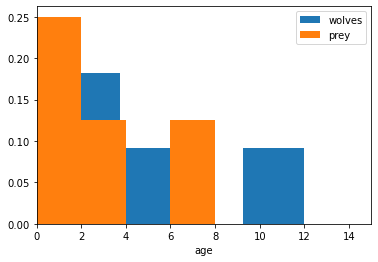

this is the end...
natural causes adverted
natural causes adverted
start noming ...
need to eat  140  bunnies
too many wolves, not enough prey
done nomnoming
Execution time: 0.0006079673767089844 seconds
done dying lol
Simulating year  1
Wolf population:  7
Prey population:  0


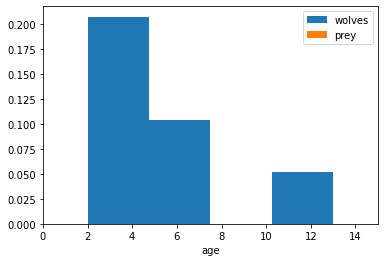

this is the end...
natural causes adverted
natural causes adverted
start noming ...
need to eat  140  bunnies
too many wolves, not enough prey
done nomnoming
Execution time: 0.00010824203491210938 seconds
done dying lol
Simulating year  2
Wolf population:  7
Prey population:  0


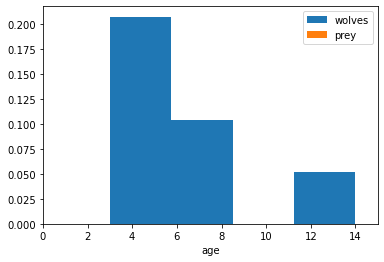

this is the end...
natural causes adverted
natural causes adverted
start noming ...
need to eat  120  bunnies
too many wolves, not enough prey
done nomnoming
Execution time: 9.703636169433594e-05 seconds
done dying lol
Simulating year  3
Wolf population:  6
Prey population:  0


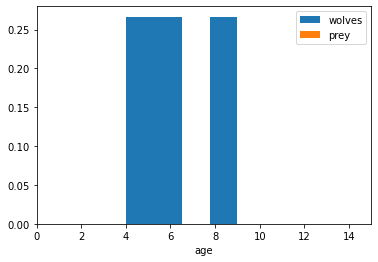

this is the end...
natural causes adverted
natural causes adverted
start noming ...
need to eat  100  bunnies
too many wolves, not enough prey
done nomnoming
Execution time: 0.00036406517028808594 seconds
done dying lol
Simulating year  4
Wolf population:  5
Prey population:  0


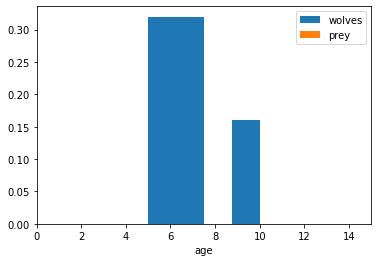

this is the end...
natural causes adverted
natural causes adverted
start noming ...
need to eat  80  bunnies
too many wolves, not enough prey
done nomnoming
Execution time: 0.0003027915954589844 seconds
done dying lol
Simulating year  5
Wolf population:  4
Prey population:  0


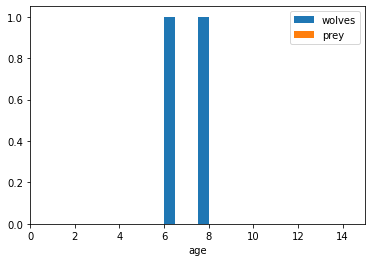

this is the end...
natural causes adverted
natural causes adverted
start noming ...
need to eat  60  bunnies
too many wolves, not enough prey
done nomnoming
Execution time: 0.0001270771026611328 seconds
done dying lol
Simulating year  6
Wolf population:  3
Prey population:  0


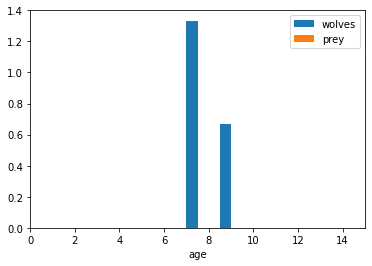

this is the end...
natural causes adverted
natural causes adverted
start noming ...
need to eat  40  bunnies
too many wolves, not enough prey
done nomnoming
Execution time: 0.00017213821411132812 seconds
done dying lol
Simulating year  7
Wolf population:  2
Prey population:  0


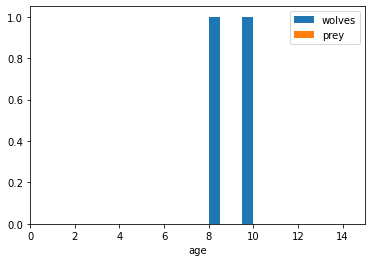

this is the end...
natural causes adverted
natural causes adverted
start noming ...
need to eat  20  bunnies
too many wolves, not enough prey
done nomnoming
Execution time: 0.00015091896057128906 seconds
done dying lol
Simulating year  8
Wolf population:  1
Prey population:  0


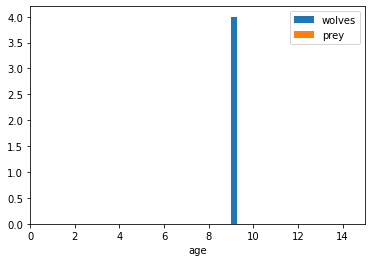

this is the end...
natural causes adverted
natural causes adverted
start noming ...
need to eat  0  bunnies
done nomnoming
Execution time: 5.412101745605469e-05 seconds
done dying lol
Simulating year  9
Wolf population:  0
Prey population:  0


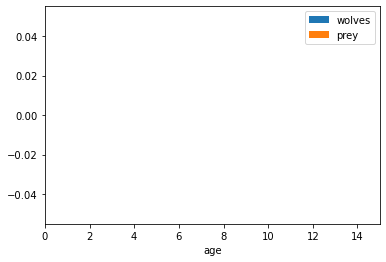

this is the end...
natural causes adverted
natural causes adverted
start noming ...
need to eat  0  bunnies
done nomnoming
Execution time: 0.00013208389282226562 seconds
done dying lol
Simulating year  10
Wolf population:  0
Prey population:  0


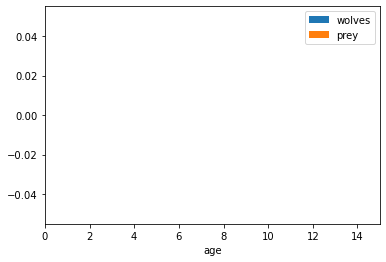

this is the end...
natural causes adverted
natural causes adverted
start noming ...
need to eat  0  bunnies
done nomnoming
Execution time: 6.699562072753906e-05 seconds
done dying lol
Simulating year  11
Wolf population:  0
Prey population:  0


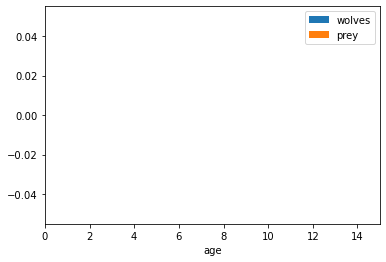

this is the end...
natural causes adverted
natural causes adverted
start noming ...
need to eat  0  bunnies
done nomnoming
Execution time: 0.00015115737915039062 seconds
done dying lol
Simulating year  12
Wolf population:  0
Prey population:  0


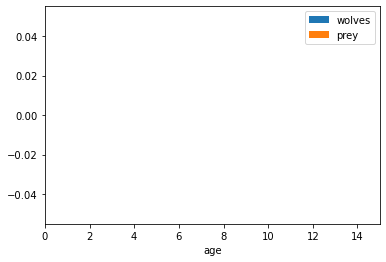

this is the end...
natural causes adverted
natural causes adverted
start noming ...
need to eat  0  bunnies
done nomnoming
Execution time: 5.817413330078125e-05 seconds
done dying lol
Simulating year  13
Wolf population:  0
Prey population:  0


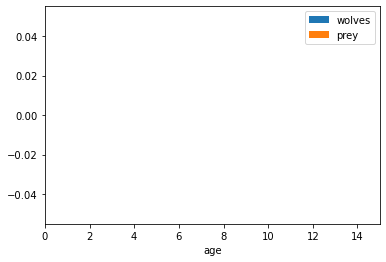

this is the end...
natural causes adverted
natural causes adverted
start noming ...
need to eat  0  bunnies
done nomnoming
Execution time: 0.00017786026000976562 seconds
done dying lol
Simulating year  14
Wolf population:  0
Prey population:  0


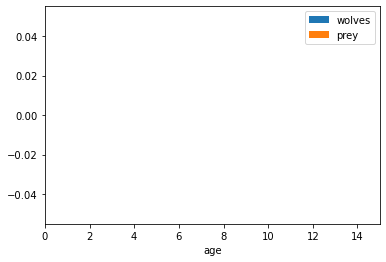

this is the end...
natural causes adverted
natural causes adverted
start noming ...
need to eat  0  bunnies
done nomnoming
Execution time: 4.601478576660156e-05 seconds
done dying lol


In [22]:
# Test cell for death functions

# create our initial animal arrays
_wolves = [wolf(1,0.50,0.50),wolf(12,0.50,0.50),wolf(6,0.50,0.50),wolf(3,0.50,0.50),
           wolf(1,0.50,0.50),wolf(12,0.50,0.50),wolf(6,0.50,0.50),wolf(3,0.50,0.50)]

_prey = [prey(1,0.50),prey(8,0.50),prey(0,0.50),prey(3,0.50),
         prey(1,0.50),prey(8,0.50),prey(0,0.50),prey(3,0.50)]

years = 15
#now iterate on the animals
for i in range(years):
    print("Simulating year ",i)
    print("Wolf population: ",len(_wolves))
    print("Prey population: ",len(_prey))
    
#     for ID, w in enumerate(_wolves):
#         print('Wolf ',ID,' age: ',w.age)
#     for ID, p in enumerate(_prey):
#         print('Prey ',ID,' age: ',p.age)
    wolfAges = [w.age for w in _wolves]
    preyAges = [p.age for p in _prey]
    
    count, bins, ignored = plt.hist(wolfAges,4, density=True,label='wolves')
    count, bins, ignored = plt.hist(preyAges,4, density=True,label='prey')
    plt.legend()
    plt.xlim(0,15)
    plt.xlabel('age')
    plt.show()

    incrementAges(_wolves,_prey) # increment ages first so that surviving animals age and new animals have age=0
    deathEvent(_wolves,_prey) # some animals die
    birthEvent(_wolves,_prey) # new animals born

In [ ]:
wolfpack, preyherd = generateExperiment(5)

In [ ]:
print("Wolf population: ",len(wolfpack))
print("Prey population: ",len(preyherd))

print("Wolf 0 age: ",wolfpack[0].age)
print("Prey 0 age: ",preyherd[0].age)